# SGD and HMC Sampler

This notebook is a simple demo of our SGD code developed in the paper "Alleviating Label Switching with Optimal Transport". The first part is devoted to the development of an HMC sampler using Stan software, while the second demonstrates our algorithm on synthetic data.

In [4]:
# List of libraries

import numpy as np
import pystan
import pickle
import matplotlib.pylab as plt
import scipy.linalg
from scipy.spatial import distance_matrix
import ot
import copy
from scipy.stats import multivariate_normal 
import time
import os, os.path
import random
import matplotlib.pyplot as plt


## 1) Data Generation and HMC Sampler

We need to implement an efficient sampler. We therefore use an Hamiltonian Monte Carlo method with the probabilistic software Stan. 

### a) Data Generation


We need first to generate data points $x \in \mathbb{R}^d$ to infer the posterior distribution $p(\Theta|x)$ via Bayes rule.

$$p(\Theta|x) \propto p(x|\Theta)p(\Theta)$$

The following code enable us to generate data points $x$ following a random Gaussian Mixture. To do so we need to generate random means and random covariance matrices. To ensure we are dealing with PSD matrices, we generate a random matrix $A$ and compute $B=AA^T$. 

The following function returns a list of points $x \in \mathbb{R}^d $ generated from a Gaussian Mixture Model where we need to prescribe a list of centers, a list of covariances, and mixture proportions. 

In [5]:
def gen_gaus_mixture(centers, covariances, mixing_prop=None, M=20000):
    
    K, D = centers.shape
    if mixing_prop is None:
        mixing_prop = np.random.dirichlet(np.ones(K)*100)
    assignments = np.random.choice(K, size=M, p=mixing_prop)
    data = np.zeros((M,D))
    
    
    for k in range(K):
        data[assignments==k] = np.random.multivariate_normal(centers[k], covariances[k], size=(assignments==k).sum())
        
    return data, mixing_prop

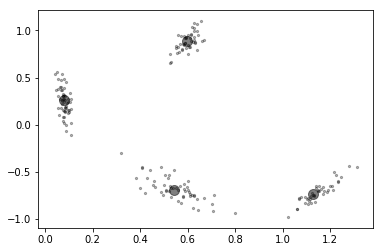

In [6]:
K = 4 # number of components
D = 2 # data dimension
M = 200 # sample size

# Random Generation of PSD matrices
cov = np.random.normal(0,0.05, (K,D,D))
for k in range(K):
    cov[k] = cov[k]@np.transpose(cov[k])

# Random Generation of Means
global_sd = np.sqrt(K)*0.5 # standard deviation for generating the means of our GMM.
mu0 = 0. 
centers = np.random.normal(mu0,global_sd,size=(K,D))


X, mix = gen_gaus_mixture(centers, cov, mixing_prop=None, M=M)

# plotting the data points

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.show()

### b) HMC Sampler

The next cell compiles the Stan and records it in a .pkl file. Indeed, compiling the Stan code takes several minutes and recording it avoids recompiling everytime one needs to use the HMC Sampler.

In [7]:
# This should be done only once because compiling the Stan code 
# takes a long time 

# mixture = pystan.StanModel(file='mixture_all.stan')
# with open('stan_mixture_all.pkl', 'wb') as f:
# pickle.dump(mixture, f)

We can now infer the posterior distribution on our parameters from these data points. The code below is for an HMC sampler from this posterior. We first need to load our pickle file, then declare the variables used in Stan. To ensure quick convergence of each chain, we carefully initialize each chain. (Additional sentence here). Finally, we plot the sampled means obtained with our HMC sampler. We refer to the documentation for implementation details https://pystan.readthedocs.io/en/latest/

The warnings thrown below by our HMC sampler are due to the label switching issue, leading consecutive samples to differ greatly. For example, the first component mean are colored in yellow, and we can see that it is located in (0.55,-0.68) and (0.59,0.88).

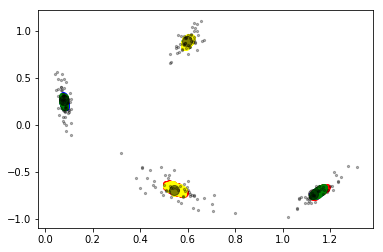

--- 219.84984183311462 seconds ---


In [8]:
mixture = pickle.load(open('Stan/stan_mixture_all.pkl', 'rb'))
start_time = time.time()

# declaring variables to Stan and number of chains 
stan_data = {'D': D, 'K':K, 'N':M, 'y':X, 'alpha':np.ones(K)*10}
chains = 3

# initialisation of each chain
local_sd=0.1
init = []
for c in range(chains):
    c_init = {'mu': np.random.normal(scale=global_sd, size=(K,D)), 'theta': np.ones(K)/K,
              'L': [np.eye(D) for _ in range(K)],
              'sigma': [np.ones(D)*local_sd for _ in range(K)]}
    init.append(c_init)
    
control={ 'adapt_delta':0.8 , 'stepsize_jitter':0.15} # control parameters
fit_nuts = mixture.sampling(data=stan_data, iter=1000, chains=chains, n_jobs=-1, init=init, control=control)
la = fit_nuts.extract(permuted=True)


## plot the results ##

colors = ['red', 'blue', 'green', 'yellow']
for k in range(K):
    plt.scatter(la['mu'][:,k,0], la['mu'][:,k,1], c=colors[k])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.show()


print("--- %s seconds ---" % (time.time() - start_time))

## SGD Algorithm 

After having implemented the HMC sampler, we need to implement our Wassertein-based SGD algorithm. We first load results given by the HMC sampler. 

The first step of our SGD-based algorithm is to randomly initialize coordinates of our barycenter. Muzellec et al. (2018) described a gradient step for PSD matrices using Cholesky matrices. Therefore we need to compute the Cholesky factor of these matrices.

For each sample  $(\mu, \Sigma, \pi)$, we compute the ditance matrix between it and our barycenter and compute the transport plan between them (in the sense described in the paper). The distance used between Gaussian distribution is 
\begin{equation}
\label{eq:w2gaussians}
 d((\bar{\mu}, \bar{\Sigma}), (\mu, \Sigma))^2 = W_2^2 (\mathcal{N}(\bar{\mu},\bar{\Sigma}), \mathcal{N}(\mu,\Sigma)) = \|\bar{\mu}-\mu\|_2^2 + \mathfrak{B}^2(\bar{\Sigma},\Sigma),
\end{equation}

Where the distance between the covariance matrices is called the Bures metric, in closed form it is 

$$\mathfrak{B}^2(\bar{\Sigma},\Sigma)= \mathrm{Tr}[\bar{\Sigma}+\Sigma-2(\bar{\Sigma}^{\frac{1}{2}}\Sigma\bar{\Sigma}^{\frac{1}{2}})^{\frac{1}{2}} ]$$


Then one should make a gradient step in the direction where the point is mapped. We recall here the gradient computation that we used in the code, we used the decomposition $\bar{\Sigma}=LL^T$
$$\nabla_{\bar{\mu}}\frac{1}{2}\|\bar{\mu}-\mu\|_2^2 = \bar{\mu}-\mu $$
$$\nabla_{\bar{\Sigma}}\frac{1}{2}\mathfrak{B}(\bar{\Sigma},\Sigma) = (I-T^{\bar{\Sigma} \Sigma})L \quad \text{with} \quad T^{\bar{\Sigma} \Sigma}= \bar{\Sigma}^{-\frac{1}{2}} (\bar{\Sigma}^{\frac{1}{2}}\Sigma\bar{\Sigma}^{\frac{1}{2}})^{\frac{1}{2}}\bar{\Sigma}^{-\frac{1}{2}}. $$ 

The stepsize is taken to be equal to $1/i$ where $i$ the number of iterations.

In [9]:
means, covs, weights, Data, likelihood= la['mu'], la['Sigma'], la['theta'].reshape((1500,4,1)), X, la['lp__']

In [10]:
def SGD(means, covs, weights, N=1000, D=2, K=4):
    start_time = time.time()
    mus = means
    mu_barre = np.random.normal(size=(K,D))
    Cov_barre  = np.array([ np.identity(D), np.identity(D),np.identity(D),np.identity(D)])
    sigma_barre = np.zeros((K,D,D))
    for i in range(K):
        sigma_barre[i] = scipy.linalg.cholesky(Cov_barre[i])
    weights_barre = (np.ones(K)/K).reshape((4,1))
    a = [1/K]*K
    b = [1/K]*K
    h = [[], [],[],[]]
    h_bis= [[], [],[],[]]
    for loop in range(1000) :
        learning_rate = 1/(loop+1)
        sigma = np.zeros((K,D,D))
        for i in range(K):
            sigma[i] = scipy.linalg.sqrtm(covs[loop,i])

        M = distance_matrix(mus[loop], mu_barre, p = 2)
        M = M**2
        M = np.ascontiguousarray(M)
        N = distance_matrix(weights[loop], weights_barre, p = 2)
        N = N**2
        N = np.ascontiguousarray(N)
        M=M+N
        for j in range(K):
            A = sigma_barre[j]@np.transpose(sigma_barre[j])
            A_demi = scipy.linalg.sqrtm(A)
            for i in range(K):
                M[i,j] += np.trace(A + covs[loop,i]- 2 * scipy.linalg.sqrtm(A_demi@covs[loop,i]@A_demi))
        T = ot.emd(a, b, M) 
        
        idx_map = np.where(T)
        learning_rate = 1/np.sqrt(loop+1)
        for j in range(K):
            s = (mu_barre[j] - mus[loop])*T[:,j].reshape(-1,1)
            mu_barre[j] -= learning_rate*2*s.sum(axis=0)
            h[j].append(copy.deepcopy(mu_barre[j]))
            assert(len(np.nonzero(T[:,j]))==1)
            i = np.nonzero(T[:,j])[0][0]                      
            A = sigma_barre[j]@np.transpose(sigma_barre[j])
            A_demi = scipy.linalg.sqrtm(A)
            T_AB =  np.real( np.linalg.inv(A_demi) @ scipy.linalg.sqrtm(A_demi@covs[loop,i]@A_demi) @  np.linalg.inv(A_demi))
            sigma_barre[j] -= learning_rate*2*(np.identity(D)-T_AB)@sigma_barre[j]
            h_bis[j].append(copy.deepcopy(sigma_barre[j]))
            weights_barre[j] -= learning_rate*2*weights[loop, i]

    for i in range(K):
        Cov_barre[i] = sigma_barre[i]@np.transpose(sigma_barre[i])
        
    return mu_barre, h, h_bis, Cov_barre, weights_barre, time.time() - start_time


In [11]:
mu_barre, h, h_bis, Cov_barre, weights_barre, timing = SGD(means, covs, weights, N=1500, D=2, K=4)

We finally plot the trajectory of our barycenter in the $(\mu_1, \mu_2)$ plane. We add also the trajectory with the corresponding covariance matrices.

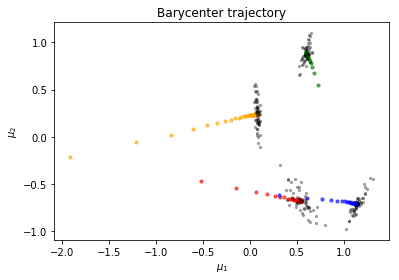

In [44]:
for i in range(K):
    x,y = zip(*h[i][:50])
    plt.scatter(x,y, color=colors[i], s=10, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.title('Barycenter trajectory')
plt.show()

Text(0.5, 1.0, 'Barycenter trajectory')

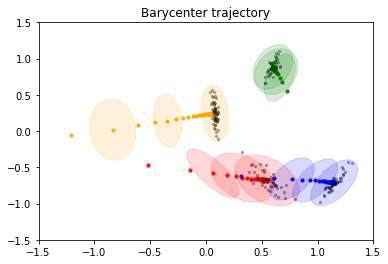

In [46]:
from matplotlib.patches import Ellipse
ax=plt.gca()

#pivot_index = np.argmax(likelihood) 
#pivot_mean, pivot_cov, pivot_weight = means[pivot_index], covs[pivot_index], weights[pivot_index]  

def plot_ellipse(pos, cov, color, label):
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height =  np.sqrt(s)

    for nsig in range(2, 3):
        ax.add_patch(Ellipse(pos, nsig * width, nsig * height,
                                 angle, alpha = 0.15, color=color, label=label))
colors = ['red', 'blue', 'green', 'orange']

for j in range(K):
    for i in [2,5,100]:
        plot_ellipse(h[j][i], h_bis[j][i], colors[j], 'yes' )
for i in range(K):
    x,y = zip(*h[i][:50])
    plt.scatter(x,y, color=colors[i],  s=10, alpha=0.9)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title('Barycenter trajectory')